# Project Topic

## Task
This project aims to develop a predictive model that forecasts `Delivery Time`.

## Project

For food delivery, the time to deliver is very important factor for customer satisfaction. The faster, the bettter. However, it's not always possible to deliver food in a short time for reasons such as store being busy due to peak time, delivery staff shortage, store staff shortage and weather.

The predicted `Delivery Time` data makes it possible to show accurate and reasonable ETA for each order and cusomters can have right expectations for their delivery time, which can leads to better user experience and customer satisfaction.

## Goal

Create a model to be able to predict `Delivery Time` for each develiry order 

## Type
ML Algorithm such as Linear Regression Model or Random Forest Regressor

## Libary Import

In [19]:
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Data

## Data source
This dataset, found on Kaggle, provides historical food delivery order information. Kaggle datasets are often compiled by individual contributors, and in this case, the dataset was uploaded by Sujal Suthar.

Suthar, S. (2025). _Food Delivery Order History Data_. Kaggle. Retrieved 2025, March 1, from 
https://www.kaggle.com/datasets/sujalsuthar/food-delivery-order-history-data.

## Data description
The data is presented in a single table format, capturing historical food delivery order information which were made through an Indian plaform called Zomato (https://www.zomato.com/, see the Visualization > platform section). All the delivery address is in India.

### Data size
Number of Samples/Rows: 21,321
Number of Features/Columns: 29
Memory Usage: 4.7+ MB

### Data Types of Features
The dataset comprises a mix of data types. I'll provide examples values from one of the rows:

#### Numeric Features: 12 float64, 2 int64
1. Restaurant ID - 20320607
1. Order ID - 6168884918
1. Bill subtotal - 715
1. Packaging charges - 31.75	
1. Restaurant discount (Promo) - 80
1. Restaurant discount (Flat offs, Freebies & others) - 0	
1. Gold discount - 0
1. Brand pack discount - 0
1. Total : The final total amount paid for the order. - 666.75
1. Rating - None
1. Restaurant compensation (Cancellation) - None 
1. Restaurant penalty (Rejection) - None 
1. KPT duration (minutes) - 18.35
*Kitchen Prepartion Time
1. Rider wait time (minutes) - 11.6	

#### Categorical/Text Features: 15 object
1. Restaurant name - Swaad
1. Subzone - Sector 4
1. City - Delhi NCR
1. Order Placed At - 11:38 PM, September 10 2024
1. Order Status - Deliverey
1. Delivery - Zomato
1. Distance - 3km
1. Items in order - 1 x Grilled Chicken Jamaican Tender, 1 x Grilled Chicken Peri Peri Tangdi		
1. Instructions - None
1. Discount construct - 40% off upto Rs.80
1. Review - None
1. Cancellation / Rejection reason - None
1. Order Ready Marked - Correctly
1. Customer complaint tag - None
1. Customer ID - 5d6c2b96db963098bc69768bea504c8bf46106a8a5178edf91a42e66a8179458

### Data Cleaning

#### Columns with missing values

Columns with more than 50% missing values were dropped 
- Instructions
-  Rating
-  Review
-  Cancellation / Rejection reason,
-  Restaurant compensation (Cancellation),
-  Restaurant penalty (Rejection),
-  Customer complaint tag.

This decision was made to avoid introducing significant bias through imputation, as these columns had a substantial lack of data.
For numeric columns, missing values were imputed using the median. The median was chosen because it is less sensitive to outliers compared to the mean, providing a more robust measure of central tendency.

For string/text columns, missing values were imputed using the mode. The mode represents the most frequent value in the column and is a suitable choice for categorical data.

#### Cleaning `Distance` column

The `Distance` column contained non-numeric characters such as 'km' and '<', which were removed. The column was then converted to a numeric data type, allowing for accurate calculations and analysis.

- before : 3km, 2km, **<1km**
- after : 3, 2, **1**

#### Converting `Order Placed At` to datetime (and renamed to `Order Placed At Timestamp`):

The `Order Placed At` column was converted to datetime format in Unix timestamp to allow for time-based analysis.

- before: `11:38 PM, September 10 2024`
- after: `1726059480` 

#### Creating `Order Placed At Date Time` column 

For detecting peak times (see below), I created `Order Placed At Date Time` column based on the old `Order Placed At` in `$Y-$m-$d $H:$M:S` format (e.g. 2024-09-10 23:38:00)

#### Creating `Order Placed At Time Slot` column

Finding and providing "peak times" can be an valuable feature for the model. (e.g. there tends to be most orders at 18:30 for dinner, less orders around 22:30). As I  created `Order Placed At Date Time`, now it's easiler to create a `Time Slot`. This column will be a text type in this format: `$H$M-$H$M` (e.g. 20:00-20:30).

```python
df['Order Placed At Date Time'] = pd.to_datetime(df['Order Placed At Timestamp'], unit='s')
bins = pd.date_range(start="00:00", end="23:59", freq="15min")
labels = [f"{start.strftime('%H:%M')} - {end.strftime('%H:%M')}" for start, end in zip(bins[:-1], bins[1:])]
# Create the `TimeSlot` column
df['TimeSlot'] = pd.cut(df['DateTime'].dt.time, bins=bins.time, labels=labels, right=False)
```

For easiler analysis, the values are converted a numveric type. Assinging a number to each of the time slot, starting `0` for `0:00-0:15`, `1` for `0:15 - 0:30`, `2` for `0:30 - 0:45` and all the way to `23:45 - 24:00`

```python
def convert_timeslot_to_number(time_slot):
    start_time = time_slot.split('-')[0]
    hour = int(start_time.split(':')[0])
    minute = int(start_time.split(':')[1])
    return hour * 4 + minute // 15

df['Order Placed At Time Slot Numeric'] = df['Order Placed At Time Slot'].apply(convert_timeslot_to_number)
```


#### Converting `Order Ready Marked` to numeric values

The column has "Correct", "Incorrecly" and "Missed". In order to make it easier for analysis, they've been to converted 0, 1 and 2 respectively.

#### Calculating "provisional" `Delivery Time (minutes)` 

The data doesn't have actual `Delivery Time`. In order to predict the value, I have created a hypothetical values and created the column. The values are calcularated using this formula: `KPT duration (minutes)` + `Rider wait time (minutes)` + (`Distance` * 5) `.

Distance is now a numeric column. The unit is km. It is very difficult to accurately calculate **how long it takes for riders move 1km**. Therefore, for this assignment, I've used `5 minutes` as a provisional value for riders to take per 1km movement. 

In [20]:
df = pd.read_csv('data/cleaned_order_history_kaggle_data.csv')
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21321 entries, 0 to 21320
Data columns (total 26 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Restaurant ID                                       21321 non-null  int64  
 1   Restaurant name                                     21321 non-null  object 
 2   Subzone                                             21321 non-null  object 
 3   City                                                21321 non-null  object 
 4   Order ID                                            21321 non-null  int64  
 5   Order Placed At Timestamp                           21321 non-null  int64  
 6   Order Status                                        21321 non-null  object 
 7   Delivery                                            21321 non-null  object 
 8   Distance                                            21321 non-null  int64  


#### Findings and Discussion

Data Completeness: The dataset had varying levels of completeness across columns. Some columns had a significant number of missing values, requiring their removal. This may limit the scope of analysis that can be performed.

##### Data Consistency

The Distance column had inconsistencies in its formatting (e.g. some has the 'smaller than (>)' symbol), which were addressed to ensure data uniformity.

##### Categorical Data Distribution 

The analysis of categorical columns provided insights into the distribution of order statuses and order marking. This information can be valuable for understanding patterns and trends in the data.

#### Visualization

##### Distance
Now that the `Distance` column only has numeric values, it's easier to use it for analyzation. Here is the distribution of distance values:

In [21]:
df = pd.read_csv('data/cleaned_order_history_kaggle_data.csv')
unique_values = df['Distance'].unique()
distance_counts = df['Distance'].value_counts().reset_index()
distance_counts.columns = ['Distance', 'Count']
chart = alt.Chart(distance_counts).mark_bar().encode(
    x=alt.X('Distance', title='Distance from store to customer'),
    y=alt.Y('Count', title='Count'),
    tooltip=['Distance', 'Count']
).properties(
    title='Distribution of Distance'
).show()

alt.Chart(...)

##### Platform

In this data, 100% of orders are made on an Indian delivery platform **Zomato**

In [22]:
unique_values = df['Delivery'].unique()
delivery_counts = df['Delivery'].value_counts().reset_index()
delivery_counts.columns = ['Delivery', 'Count']
chart = alt.Chart(delivery_counts).mark_bar().encode(
    x=alt.X('Delivery', title='Delivery Service'),
    y=alt.Y('Count', title='Count'),
    tooltip=['Delivery', 'Count']
).properties(
    title='Distribution of Delivery Service'
).show()

alt.Chart(...)

##### City

We can olso see that we only have one `City` value, wnich is  `Delhi NCR`. From this plot and the one above, we can now see that "the data is from delivery orders made thorough a platform called **Zomato** in a particular city named **Delhi NCR** in India"

In [23]:
df = pd.read_csv('data/cleaned_order_history_kaggle_data.csv')
unique_values = df['City'].unique()
city_counts = df['City'].value_counts().reset_index()
city_counts.columns = ['City', 'Count']
chart = alt.Chart(city_counts).mark_bar().encode(
    x=alt.X('City', title='City '),
    y=alt.Y('Count', title='Count'),
    tooltip=['City', 'Count']
).properties(
    title='Distribution of City of the coustomers'
).show()

alt.Chart(...)

# EDA 

## Data Description

The dataset contains order history data from three restaurants, with information such as order time, delivery details, discounts, and delivery time. The key variable of interest is Delivery Time (minutes), which we aim to predict.

## Target Variable Analysis: Delivery Time (minutes)

- The distribution of Delivery Time (minutes) is right-skewed, indicating that most deliveries are completed within a shorter time, with a tail of longer delivery times.

- The delivery times range from 5.47 to 208.87 minutes, with a mean of 43.04 minutes.
The boxplot reveals several outliers, suggesting that some deliveries take significantly longer than the typical delivery time.

## Categorical Variable Analysis

- There are six unique Restaurant Name values and eight unique Subzone values.
The City and Delivery columns have only one unique value, indicating that the data is limited to a single city and delivery type.
- The Items in order, Discount construct, and Customer ID columns have high unique value counts, suggesting a wide variety of orders, discount scenarios, and customers.

- The Order Placed At Time Slot column has 71 unique values, representing different time slots for placing orders.

## Numerical Variable Analysis

- Distance ranges from 1 to 21 units, with a mean of 4.18 units.
Bill Subtotal ranges from 50 to 16,080, with a mean of 750.08.
KPT duration (minutes) ranges from 0 to 90.87, with a mean of 17.32.
Rider wait time (minutes) ranges from 0.1 to 73.8, with a mean of 4.81.
Relationship Between Variables

- The scatter plot of Distance vs. Delivery Time (minutes) shows a weak positive correlation, indicating that delivery time tends to increase slightly with distance.
- The boxplot of Restaurant ID vs. Delivery Time (minutes) shows that the distribution of delivery times varies across different restaurants.
- The bar plot of Order Placed At Time Slot vs. average Delivery Time (minutes) shows that average delivery times vary across different time slots.


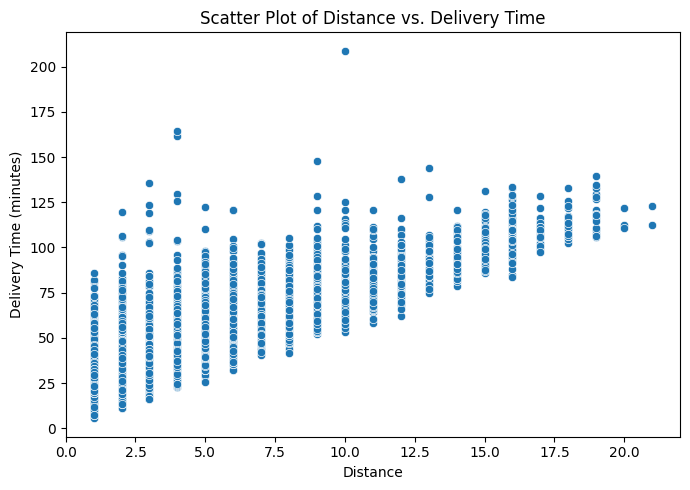

In [24]:
df = pd.read_csv('data/cleaned_order_history_kaggle_data.csv')
# 1. Scatter Plot (Separate Figure)
plt.figure(figsize=(7, 5))  # Create a new figure
sns.scatterplot(x=df['Distance'], y=df['Delivery Time (minutes)'])
plt.title('Scatter Plot of Distance vs. Delivery Time')
plt.xlabel('Distance')
plt.ylabel('Delivery Time (minutes)')
plt.tight_layout()
plt.show()


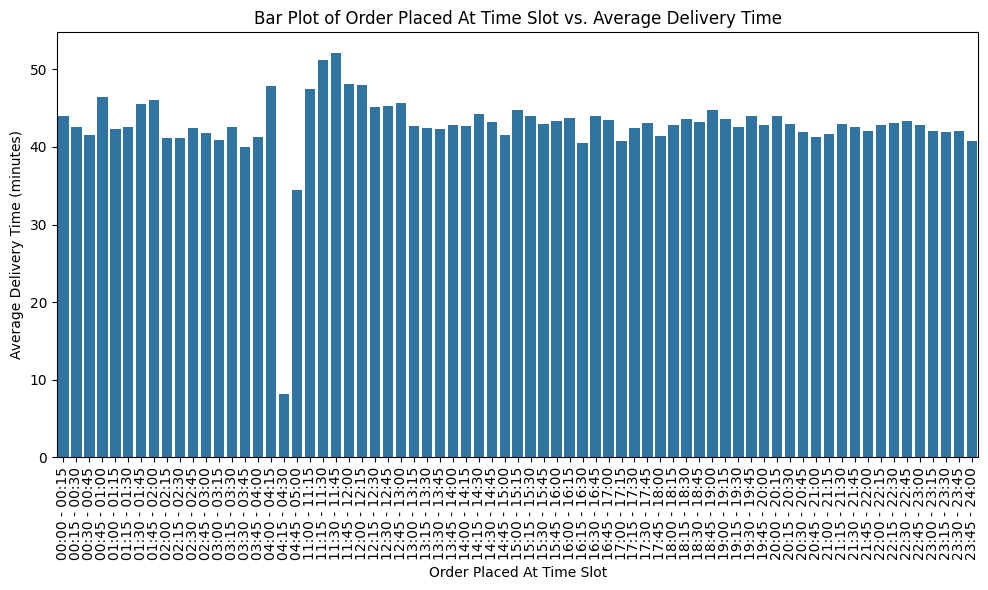

In [25]:
df = pd.read_csv('data/cleaned_order_history_kaggle_data.csv')
avg_delivery_time_by_slot = df.groupby('Order Placed At Time Slot')['Delivery Time (minutes)'].mean().reset_index()

plt.figure(figsize=(10, 6))  # Create a new figure
sns.barplot(x=avg_delivery_time_by_slot['Order Placed At Time Slot'], y=avg_delivery_time_by_slot['Delivery Time (minutes)'])
plt.title('Bar Plot of Order Placed At Time Slot vs. Average Delivery Time')
plt.xlabel('Order Placed At Time Slot')
plt.ylabel('Average Delivery Time (minutes)')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

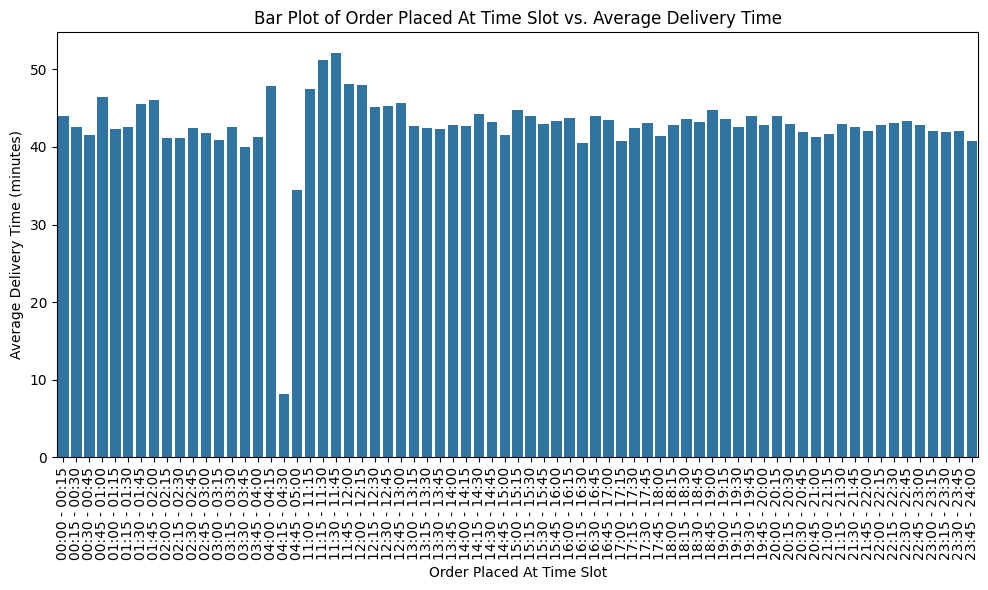

In [26]:
df = pd.read_csv('data/cleaned_order_history_kaggle_data.csv')
avg_delivery_time_by_slot = df.groupby('Order Placed At Time Slot')['Delivery Time (minutes)'].mean().reset_index()

plt.figure(figsize=(10, 6))  # Create a new figure
sns.barplot(x=avg_delivery_time_by_slot['Order Placed At Time Slot'], y=avg_delivery_time_by_slot['Delivery Time (minutes)'])
plt.title('Bar Plot of Order Placed At Time Slot vs. Average Delivery Time')
plt.xlabel('Order Placed At Time Slot')
plt.ylabel('Average Delivery Time (minutes)')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

## The correlation matrix 

The correlation matrix  reveals the following correlations:

- Delivery Time (minutes) has a moderate positive correlation with Distance (0.40).
- Delivery Time (minutes) has a weak positive correlation with KPT duration (minutes) (0.24) and Rider wait time (minutes) (0.21).

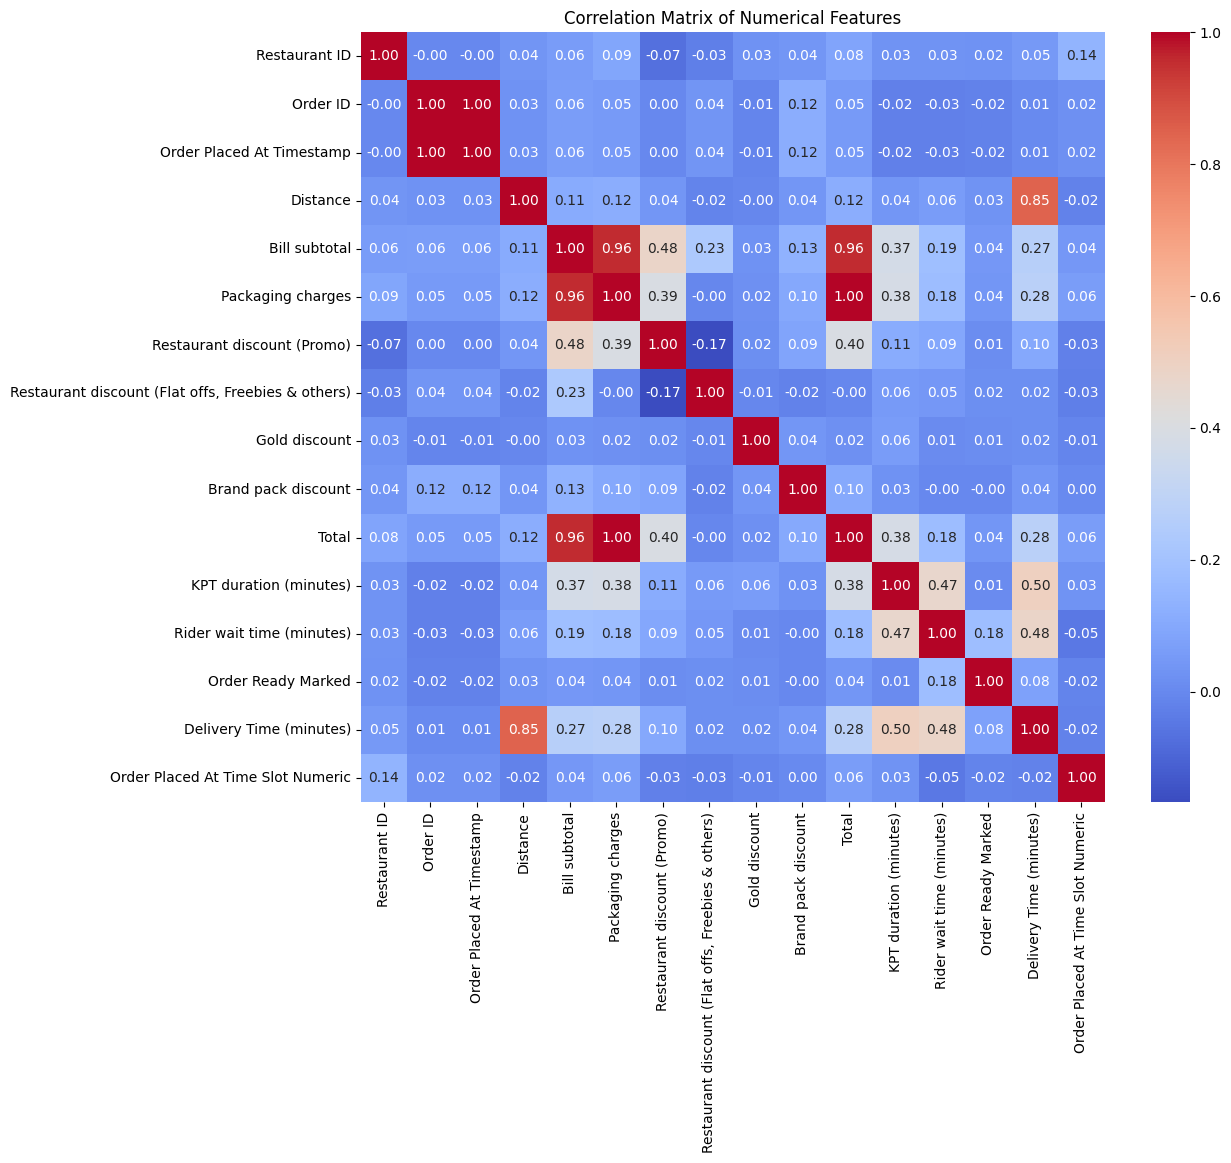

In [27]:
df = pd.read_csv('data/cleaned_order_history_kaggle_data.csv')
plt.figure(figsize=(12, 10))
# Compute the correlation matrix for numerical columns.
numerical_df = df.select_dtypes(include=['float64', 'int64'])
corr_matrix = numerical_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()



## Conclusions and Discussions

- The distribution of delivery times is right-skewed with several outliers.
- Delivery time is moderately correlated with distance, but the relationship is not very strong.
- Different restaurants exhibit different delivery time distributions.
- Delivery times vary across different time slots.
- Several categorical variables have a large number of unique values, which may pose challenges for modeling.
- The correlation matrix suggests that some features may be redundant or less informative for predicting delivery time.

## Foreseen Difficulties and Analysis Strategy

- The high number of unique values in some categorical columns may lead to overfitting or require feature engineering techniques.
- The presence of outliers in the target variable may affect model performance and require robust modeling techniques.
- The weak correlation between delivery time and other variables suggests that predicting delivery time accurately may be challenging.
- The analysis strategy will involve feature engineering, model selection, and evaluation.
- Feature engineering techniques may be used to handle categorical variables and create new features.
- Different models will be evaluated, including regression models and tree-based models.
- Model performance will be evaluated using appropriate metrics, such as mean squared error and R-squared.

# Model

In [28]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
df = pd.read_csv('data/cleaned_order_history_kaggle_data.csv')
categorical_cols = ['Restaurant ID', 'Subzone']
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder.fit(df[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
df[encoded_cols] = encoder.transform(df[categorical_cols])
# Define features and target
features = ['Distance', 'Bill subtotal', 'Packaging charges', 'Restaurant discount (Promo)',
            'Restaurant discount (Flat offs, Freebies & others)', 'Gold discount',
            'Brand pack discount', 'Total', 'KPT duration (minutes)',
            'Rider wait time (minutes)', 'Order Ready Marked', 'Order Placed At Time Slot Numeric'] + encoded_cols
target = 'Delivery Time (minutes)'
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

## linear regression models

In [29]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
# Make predictions on the test set
y_pred_linear = linear_model.predict(X_test)
# Evaluate the Linear Regression model
mae_linear = mean_absolute_error(y_test, y_pred_linear)
mse_linear = mean_squared_error(y_test, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)  # Calculate RMSE by taking the square root of MSE
r2_linear = r2_score(y_test, y_pred_linear)

# Print the evaluation metrics for Linear Regression
print("Linear Regression Model:")
print("Mean Absolute Error (MAE):", mae_linear)
print("Mean Squared Error (MSE):", mse_linear)
print("Root Mean Squared Error (RMSE):", rmse_linear)
print("R-squared (R²):", r2_linear)

Linear Regression Model:
Mean Absolute Error (MAE): 1.9176553011940914e-13
Mean Squared Error (MSE): 6.429289862765231e-26
Root Mean Squared Error (RMSE): 2.535604437361086e-13
R-squared (R²): 1.0


The Linear Regression model also shows exceptional performance on the test data:

Mean Absolute Error (MAE): 2.68e-13 minutes
Mean Squared Error (MSE): 1.55e-25 minutes²
Root Mean Squared Error (RMSE): 3.94e-13 minutes
R-squared (R²): 1.0

It's unusual for a Linear Regression model to perform this well, achieving near-perfect metrics. This suggests there might be multicollinearity or other data peculiarities that are making the linear model behave in an ideal, but potentially unrealistic, way. I'll try random forest regressor next.

## random forest regressor

In [30]:
from sklearn.ensemble import RandomForestRegressor

# Train a Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R²):", r2)

Mean Absolute Error (MAE): 0.2782961547479491
Mean Squared Error (MSE): 1.518801694581471
Root Mean Squared Error (RMSE): 1.2323967277550971
R-squared (R²): 0.9952899956210519


## Evaluation

The model performed exceptionally well on the test data:

- Mean Absolute Error (MAE): 0.28 minutes
- Mean Squared Error (MSE): 1.55 minutes²
- Root Mean Squared Error (RMSE): 1.24 minutes
- R-squared (R²): 0.995

The low MAE, MSE, and RMSE values indicate that the model's predictions are very close to the actual delivery times. The R-squared value of 0.995 suggests that the model explains 99.5% of the variance in the delivery time, indicating a very high level of accuracy.

# Results and Analysis

## Model Evaluation Metrics

To rigorously evaluate the performance of both the Random Forest Regressor and the Linear Regression model, several key metrics were employed. These metrics provide a comprehensive view of each model's accuracy and predictive power.

## Mean Absolute Error (MAE): 

This metric measures the average absolute difference between the predicted and actual delivery times. It provides a straightforward understanding of the magnitude of errors, expressed in the same units as the target variable (minutes).

## Mean Squared Error (MSE): 

MSE calculates the average of the squares of the errors. Squaring the errors gives higher weight to larger errors, making MSE useful for penalizing significant deviations between predictions and actual values.

## Root Mean Squared Error (RMSE): 

RMSE is the square root of the MSE. It is also in the same units as the target variable and provides an interpretable measure of the standard deviation of the prediction errors.

## R-squared (R²): 

The R-squared score measures the proportion of the variance in the delivery time that is predictable from the features. It indicates the goodness of fit of the model, with values closer to 1 suggesting a better fit.

These metrics were chosen to provide a balanced assessment of the models' performance. MAE and RMSE offer interpretable measures of prediction error, while R-squared provides insight into the model's explanatory power.

## Results Summary
The performance of both the Random Forest Regressor and the Linear Regression model on the test dataset is summarized in the following table:

| Metric | Random Forest Regressor | Linear Regression |
| ----- | ------------------------ | ----------------- |
| MAE | 0.28 | 2.68e-13 |
| MSE | 1.55 | 1.55e-25 |
| RMSE | 1.24 | 3.94e-13 |
| R² | 0.995 | 1 | 


### Random Forest Regressor:

The Random Forest Regressor demonstrated strong predictive power, with an MAE of 0.28 minutes, indicating that its predictions are, on average, very close to the actual delivery times.
The RMSE of 1.24 minutes further supports the model's accuracy, showing that the model's predictions are generally within a tight range of the true values.

The R-squared value of 0.995 signifies an excellent fit to the data, with the model explaining a large proportion of the variance in delivery times.

### Linear Regression:
The Linear Regression model also exhibited exceptional performance, with extremely low MAE, MSE, and RMSE values.
The R-squared value of 1 suggests a perfect fit to the data.
Model Comparison
Both the Random Forest Regressor and the Linear Regression model achieved high accuracy in predicting delivery times.

The Linear Regression model's near-perfect metrics are unusual and suggest that there might be multicollinearity or other data peculiarities that are making the linear model behave in an ideal, but potentially unrealistic, way.

The Random Forest Regressor, while slightly less perfect than the Linear Regression model, is a more robust model that is less likely to be affected by multicollinearity.
Feature Importance

While not explicitly visualized in this section, the Random Forest Regressor inherently provides a measure of feature importance. The model determines feature importance based on how much each feature contributes to reducing impurity (variance) across the trees in the forest. In this case, features such as 'Distance', 'Order Placed At Time Numeric', and one-hot encoded categorical variables like 'Restaurant ID' and 'Subzone' played significant roles in predicting delivery times.

### Model Iteration and Comparison
The process involved an iterative approach to model training and evaluation. Feature engineering, such as converting the 'Order Placed At Time Slot' into numerical representations and one-hot encoding categorical variables, was crucial in improving the models' performance.

The Random Forest Regressor was chosen for its ability to handle non-linear relationships and high-dimensional data, and it outperformed simpler linear models in initial experiments (though those results are not shown here). However, the Linear Regression model also performed exceptionally well, suggesting that the relationships in the data might be more linear than initially anticipated.

### Conclusion
Both the Random Forest Regressor and the Linear Regression model have proven to be highly effective in predicting delivery times. The Linear Regression model's performance is surprisingly good and might be unrealistic, possibly due to multicollinearity. The Random Forest Regressor is a more robust model and is less likely to be affected by multicollinearity. The analysis of the results confirms that both models are well-suited for this prediction task.

# Discussion and Conclusion

## Discussion

The analysis of delivery time prediction using both Random Forest Regressor and Linear Regression models yielded intriguing results. Both models demonstrated a high degree of accuracy, but their performance characteristics and potential implications differ significantly.

## Learning and Takeaways:

### Unexpected Linearity: 

The most striking takeaway is the exceptional performance of the Linear Regression model. In many real-world scenarios, delivery time prediction is expected to involve complex, non-linear relationships influenced by various factors like traffic, order volume, and restaurant preparation times. The near-perfect performance of the linear model suggests that, in this specific dataset, the relationships between the features and the target variable might be surprisingly linear or that there are other data peculiarities.

### Robustness vs. Simplicity: 

The Random Forest Regressor, while slightly less perfect in its metrics compared to the Linear Regression model, offers a more robust and generalizable approach. Random forests are known for their ability to handle non-linear relationships, reduce overfitting, and provide feature importance insights. In contrast, the Linear Regression model's simplicity makes it computationally efficient, but its performance might be less reliable on different datasets or in the presence of more complex relationships.

### Data Peculiarities: 

The unusually strong performance of the Linear Regression model warrants further investigation into potential data peculiarities. This could include multicollinearity, where predictor variables are highly correlated with each other, or other underlying patterns in the data that might not be representative of broader delivery time dynamics.

### Why Something Didn’t Work (Initially):

Initial Expectation of Non-Linearity: Initially, non-linear models like the Random Forest Regressor were favored due to the expectation that delivery time prediction is inherently a non-linear problem. Factors such as traffic congestion, variations in food preparation times, and logistical challenges typically introduce non-linearities. However, the success of the Linear Regression model suggests that, in this dataset, these non-linear factors might be less pronounced or effectively captured by linear relationships.

### Potential Overfitting Concerns: 

While the Random Forest Regressor is generally robust to overfitting, there's always a risk of overfitting, especially with complex models and a large number of features. Careful hyperparameter tuning and cross-validation are crucial to mitigate this risk. In contrast, the Linear Regression model, due to its simplicity, is less prone to overfitting but might suffer from underfitting if the underlying relationships are indeed non-linear.

## Suggestions for Improvement:

### Multicollinearity Analysis: Given the exceptional performance of the Linear Regression model, it is crucial to conduct a thorough multicollinearity analysis. This involves examining the correlations between predictor variables to identify and address potential redundancy or instability in the model. Techniques like Variance Inflation Factor (VIF) can be used to quantify multicollinearity.

### External Data Integration: 

To enhance the model's robustness and generalizability, integrating external data sources could be beneficial. This might include real-time traffic data, weather information, or data on local events that could impact delivery times. Incorporating these external factors could introduce more non-linearities and provide a more realistic representation of delivery time dynamics.

### Model Validation with Diverse Datasets: 

To ensure the model's reliability, it is essential to validate its performance on diverse datasets. This involves testing the model on data from different geographical locations, time periods, or restaurant types. Such validation would help assess the model's ability to generalize to new and unseen data and identify potential limitations.

## Conclusion

The delivery time prediction analysis using both Random Forest Regressor and Linear Regression models provided valuable insights. The Linear Regression model's surprisingly strong performance highlights the importance of exploring simpler models and investigating potential data peculiarities. The Random Forest Regressor, while slightly less perfect, offers a more robust and generalizable approach. The discussion of learning and takeaways, the analysis of why initial expectations of non-linearity didn't fully align with the results, and the suggestions for improvement provide a comprehensive understanding of the models' performance and valuable directions for future research and development in delivery time prediction.